# Implementing ANNs with TensorFlow
# Final Project: Chess Playing Environment for DeepChess
# Group 12: Renato Garita Figueiredo, Hamza Kebiri, Turan Orujlu

### Imports

In [1]:
import numpy as np
import random
import tensorflow as tf
import chess
import chess.svg
from IPython.display import display, clear_output

C:\Users\Turan Orujlu\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### DeepChess Data

In [2]:
class DeepChessData(object):
    
    def __init__(self, win_file, loss_file):
        
        win_data = np.load(win_file)['arr_0']
        loss_data = np.load(loss_file)['arr_0']
        
        # Small value to avoid zero division
        epsilon = 1e-9
        
        # Take win data samples for population moments calculation
        # It is computationally expensive to do it for the full data
        np.random.seed(0)
        indices_w = np.random.choice(len(win_data), size = 250000, replace = False)
        win_samples = win_data[indices_w]
        
        # Clean the cache
        del win_data
        del indices_w
        
        # Take loss data samples for population moments calculation
        # It is computationally expensive to do it for the full data
        np.random.seed(1)
        indices_l = np.random.choice(len(loss_data), size = 250000, replace = False)
        loss_samples = loss_data[indices_l]
        
        # Clean the cache
        del loss_data
        del indices_l
        
        # Combine win and loss samples
        samples = np.concatenate((win_samples, loss_samples))
        
        # Clean the cache
        del win_samples
        del loss_samples
        
        # Calculate population moments
        self.avg = np.mean(samples, 0)
        self.std = np.std(samples, 0) + epsilon
        
        # Clean the cache
        del samples

### Autoencoder

In [3]:
# Class that defines the behavior of an Autoencoder
class Autoencoder(object):
    
    # Encode input with input_size as an output with output_size
    def __init__(self, input_size, output_size):
        
        # Defining the hyperparameters
        self.input_size = input_size # The input size
        self.output_size = output_size # The output size
        
        # Training weights and biases
        self.weights = {}
        self.biases = {}
        
        # Encoder
        with tf.variable_scope('encoder_vars'):
            
            # ReLU weights
            var_init = tf.truncated_normal_initializer(stddev = 2 / input_size)
            self.weights['encoder_h'] = tf.get_variable('encoder_h_' + str(input_size) + '_-_' + str(output_size),
                                                        [input_size, output_size],
                                                        tf.float32,
                                                        var_init)
            
            # ReLU biases
            var_init = tf.constant_initializer(0.01)
            self.biases['encoder_b'] = tf.get_variable('encoder_b' + str(output_size),
                                                       [output_size],
                                                       tf.float32,
                                                       var_init)
        
        # Decoder
        with tf.variable_scope('decoder_vars'):

            # ReLU weights
            var_init = tf.truncated_normal_initializer(stddev = 2 / input_size)
            self.weights['decoder_h'] = tf.get_variable('decoder_h' + str(output_size) + '_-_' + str(input_size),
                                                        [output_size, input_size],
                                                        tf.float32,
                                                        var_init)
            
            # ReLU biases
            var_init = tf.constant_initializer(0.01)
            self.biases['decoder_b'] = tf.get_variable('decoder_b' + str(input_size),
                                                       [input_size], 
                                                       tf.float32,
                                                       var_init)
    
        # Input
        self.X = tf.placeholder(tf.float32, [None, self.input_size])
        
        # Stage indicator for batch normalization
        self.is_training = tf.placeholder(tf.bool, None)

        # Construct model
        with tf.variable_scope('encoder_op'):
            self.encoder_op = self.encoder(self.X, True)
        with tf.variable_scope('decoder_op'):
            decoder_op = self.decoder(self.encoder_op, True)

        # Prediction
        y_pred = decoder_op
    
    # Batch Normalization with population parameters (non-training)
    def _pop_batch_norm(self, x, pop_mean, pop_var, offset, scale):
            return tf.nn.batch_normalization(x, pop_mean, pop_var, offset, scale, 1e-6)

    # Batch Normalization with batch parameters (training)
    def _batch_norm(self, x, pop_mean, pop_var, mean, var, offset, scale):
        decay = 0.99

        dependency_1 = tf.assign(pop_mean, pop_mean * decay + mean * (1 - decay))
        dependency_2 = tf.assign(pop_var, pop_var * decay + var * (1 - decay))

        with tf.control_dependencies([dependency_1, dependency_2]):
            return tf.nn.batch_normalization(x, mean, var, offset, scale, 1e-6)

    # Batch Normalization
    def _batch_normalize(self, x, axes):
        depth = x.shape[-1]
        mean, var = tf.nn.moments(x, axes = axes)

        var_init = tf.constant_initializer(0.0)
        offset = tf.get_variable('offset', [depth], tf.float32, var_init)
        var_init = tf.constant_initializer(1.0)
        scale = tf.get_variable('scale', [depth], tf.float32, var_init)

        pop_mean = tf.get_variable('pop_mean', [depth], initializer = tf.zeros_initializer(), trainable = False)
        pop_var = tf.get_variable('pop_var', [depth], initializer = tf.ones_initializer(), trainable = False)

        return tf.cond(
            self.is_training,
            lambda: self._batch_norm(x, pop_mean, pop_var, mean, var, offset, scale),
            lambda: self._pop_batch_norm(x, pop_mean, pop_var, offset, scale)
        )
    
    # Building the encoder: encode the input with ReLU activation
    def encoder(self, x, normalize = False):

        activation = tf.add(tf.matmul(x, self.weights['encoder_h']), self.biases['encoder_b'])

        # Batch Normalization
        if normalize:
            activation = self._batch_normalize(activation, [0])

        return tf.nn.relu(activation)

    # Building the decoder: decode the input with ReLU activation
    def decoder(self, x, normalize = False):

        activation = tf.add(tf.matmul(x, self.weights['decoder_h']), self.biases['decoder_b'])

        # Batch Normalization
        if normalize:
            activation = self._batch_normalize(activation, [0])

        return tf.nn.relu(activation)
    
    # Encoder output method for the Deep Belief Network
    def encoder_output(self, sess, X):
        
        return sess.run(self.encoder_op, feed_dict = {self.X: X, self.is_training: False})

### Deep Belief Network

In [4]:
# Class that defines the behavior of a Deep Belief Network
class DeepBeliefNetwork(object):
    
    # Create layers of Autoencoders with sizes dbn_layer_sizes
    def __init__(self, dbn_layer_sizes):
        
        print("Initializing the Deep Belief Network Data Flow Graph ...")
        
        # Create list to hold the Autoencoders
        self.autoencoders = []
        
        # For each Autoencoder we want to generate
        for i in range(len(dbn_layer_sizes) - 1):
            with tf.variable_scope('Autoencoder_' + str(i + 1)):
                input_size = dbn_layer_sizes[i]
                output_size = dbn_layer_sizes[i + 1]
                print("Autoencoder ", i + 1, ": ", input_size, "->", output_size, "->", input_size)
                self.autoencoders.append(Autoencoder(input_size, output_size))
                
        print("The Deep Belief Network Data Flow Graph is initialized!")

### Siamese Network

In [5]:
# Class that defines the behavior of a Siamese Network
class SiameseNetwork(object):
    
    # Stack fin_layer_sizes on top of a pair of deep_belief_network
    def __init__(self, deep_belief_network, fin_layer_sizes):
        
        print("Initializing the Siamese Network Data Flow Graph ...")
        
        # List to hold stage indicators for batch normalization in the Deep Belief Network
        self.is_training_list = []
        
        # Deep Belief Network
        for i, autoencoder in enumerate(deep_belief_network.autoencoders):
            print("DBN Layer ", i + 1, ": ", autoencoder.input_size, "->", autoencoder.output_size)
            self.is_training_list.append(autoencoder.is_training)
            
        # Training weights and biases
        self.fin_weights = []
        self.fin_biases = []
        
        # Final layers
        with tf.variable_scope('final_layers'):

            input_size = 2 * autoencoder.output_size
            for i, fin_layer_size in enumerate(fin_layer_sizes):
                output_size = fin_layer_size
                
                # ReLU weights
                var_init = tf.truncated_normal_initializer(stddev = 2 / input_size)
                
                # Non-ReLU weights for the last layer
                if (i == len(fin_layer_sizes) - 1):
                    var_init = tf.truncated_normal_initializer(stddev = input_size ** (-1/2))                    
                
                self.fin_weights.append(tf.get_variable('fin_weights_' + str(i) + '_' + str(input_size) + '_-_' + str(output_size),
                                                        [input_size, output_size],
                                                        tf.float32,
                                                        var_init))
                
                # ReLU biases
                var_init = tf.constant_initializer(0.01)
                
                # Non-ReLU biases for the last layer
                if (i == len(fin_layer_sizes) - 1):
                    var_init = tf.constant_initializer(0.0)
                
                self.fin_biases.append(tf.get_variable('fin_biases_' + str(i) + '_' + str(output_size),
                                                       [output_size],
                                                       tf.float32,
                                                       var_init))
                
                print("Final Layer ", i + 1, ": ", input_size, "->", output_size)
                input_size = output_size
            
        # First and second inputs
        self.X1 = tf.placeholder(tf.float32, [None, deep_belief_network.autoencoders[0].input_size])
        self.X2 = tf.placeholder(tf.float32, [None, deep_belief_network.autoencoders[0].input_size])
        
        # Stage indicator for batch normalization in final layers
        self.is_training = tf.placeholder(tf.bool, None)

        # Construct model
        dbn_forward_pass_op1 = self.dbn_forward_pass(self.X1, deep_belief_network.autoencoders)
        dbn_forward_pass_op2 = self.dbn_forward_pass(self.X2, deep_belief_network.autoencoders)
        X = tf.concat([dbn_forward_pass_op1, dbn_forward_pass_op2], axis = 1)
        input_X = X
        for i in range(len(fin_layer_sizes) - 1):
            with tf.variable_scope('fin_forward_pass_op_' + str(i + 1)):
                fin_weights = self.fin_weights[i]
                fin_biases = self.fin_biases[i]
                input_X = self.fin_forward_pass(input_X, fin_weights, fin_biases, True, tf.nn.relu)
        fin_weights = self.fin_weights[-1]
        fin_biases = self.fin_biases[-1]
        with tf.variable_scope('fin_forward_pass_op_' + str(len(fin_layer_sizes))):
            self.fin_forward_pass_op = self.fin_forward_pass(input_X, fin_weights, fin_biases, True)
        
        print("The Siamese Network Data Flow Graph is initialized!")
        
    # Batch Normalization with population parameters (non-training)
    def _pop_batch_norm(self, x, pop_mean, pop_var, offset, scale):
            return tf.nn.batch_normalization(x, pop_mean, pop_var, offset, scale, 1e-6)

    # Batch Normalization with batch parameters (training)
    def _batch_norm(self, x, pop_mean, pop_var, mean, var, offset, scale):
        decay = 0.99

        dependency_1 = tf.assign(pop_mean, pop_mean * decay + mean * (1 - decay))
        dependency_2 = tf.assign(pop_var, pop_var * decay + var * (1 - decay))

        with tf.control_dependencies([dependency_1, dependency_2]):
            return tf.nn.batch_normalization(x, mean, var, offset, scale, 1e-6)

    # Batch Normalization
    def _batch_normalize(self, x, axes):
        depth = x.shape[-1]
        mean, var = tf.nn.moments(x, axes = axes)

        var_init = tf.constant_initializer(0.0)
        offset = tf.get_variable('offset', [depth], tf.float32, var_init)
        var_init = tf.constant_initializer(1.0)
        scale = tf.get_variable('scale', [depth], tf.float32, var_init)

        pop_mean = tf.get_variable('pop_mean', [depth], initializer = tf.zeros_initializer(), trainable = False)
        pop_var = tf.get_variable('pop_var', [depth], initializer = tf.ones_initializer(), trainable = False)

        return tf.cond(
            self.is_training,
            lambda: self._batch_norm(x, pop_mean, pop_var, mean, var, offset, scale),
            lambda: self._pop_batch_norm(x, pop_mean, pop_var, offset, scale)
        )    
    
    # Pass the input through the Deep Belief Network
    def dbn_forward_pass(self, x, autoencoders):

        output = x

        for i, autoencoder in enumerate(autoencoders):
            with tf.variable_scope('Autoencoder_' + str(i + 1)):
                with tf.variable_scope('encoder_op', reuse = True):
                    output = autoencoder.encoder(output, True)

        return output

    # Building final layers: pass the input through the layers with given activation functions
    def fin_forward_pass(self, x, weights, biases, normalize = False, activation_function = None):
        activation = tf.add(tf.matmul(x, weights), biases)

        # Batch Normalization
        if normalize:
            activation = self._batch_normalize(activation, [0])

        return activation_function(activation) if callable(activation_function) else activation
    
    # Evaluate the Siamese Network
    def evaluate(self, sess, X1, X2):
        
        feed_dict = {self.X1: X1, self.X2: X2, self.is_training: False}
        for is_training in self.is_training_list:
            feed_dict[is_training] = False
        
        return sess.run(self.fin_forward_pass_op, feed_dict = feed_dict)

### Minimax Algorithm

In [6]:
# Class that defines the behavior of the Minimax Algorithm
# with comparison-based alpha-beta search
class Minimax(object):
    
    def __init__(self, sess, deep_chess, deep_chess_data):
        
        self.sess = sess # tensorflow session
        self.deep_chess = deep_chess # heuristic function
        self.avg = deep_chess_data.avg # population average for input normalization
        self.std = deep_chess_data.std # population standard deviation for input normalization
    
    # Converts the chess.Board representation of the position
    # to a binary bit-string representation called bitboard.
    def _normalized_bitboard(self, board):
        
        # binary bit-string
        bitboard = np.zeros(773, dtype=bool)

        # every piece on the board gets its bit-representation
        piece_map = board.piece_map()
        for square in piece_map.keys():
            piece = piece_map[square]
            color = int(piece.color)
            piece_type = piece.piece_type
            index = (1 - color) * 6 * 64 + (piece_type - 1) * 64 + square
            bitboard[index] = 1

        # side to move
        bitboard[768] = int(board.turn)

        # castling rights
        bitboard[769] = int(board.has_kingside_castling_rights(chess.WHITE))
        bitboard[770] = int(board.has_queenside_castling_rights(chess.WHITE))
        bitboard[771] = int(board.has_kingside_castling_rights(chess.BLACK))
        bitboard[772] = int(board.has_queenside_castling_rights(chess.BLACK))

        # normalize the bitboard representation
        bitboard = (bitboard - self.avg) / self.std
        
        return np.reshape(bitboard, (1, 773))
    
    # Fail-hard alpha-beta algorithm (max player)
    def alpha_beta_max(self, board, alpha_pos, alpha_move, beta_pos, beta_move, depth):
        
        # Return the normalized bitboard representation when
        # the node is a final one or the depth limit is reached
        if depth == 0 or board.is_game_over():
            
            return self._normalized_bitboard(board), None

        # Copy the board
        child_board = board.copy()
        
        # Randomize legal moves
        legal_moves = random.sample(list(board.legal_moves), len(list(board.legal_moves)))

        # For every legal move,
        for move in legal_moves:
            
            # Make the move on the copy
            child_board.push(move)

            # Get the result of the move of the min player
            pos, _ = self.alpha_beta_min(child_board, alpha_pos, alpha_move, beta_pos, beta_move, depth - 1)
            
            # If the resulting position is better than the beta position, return the
            # beta position which is the least best position for the max player that
            # the min player is assured of. This represents fail-hard beta-cutoff.
            # Having a guaranteed worse outcome for the max player, the min player
            # won't enter this node since the max player has at least one move in
            # this node with an outcome that dominates beta position. Note: None
            # corresponds to an infinitely good outcome for the max player when
            # assigned to the beta position.
            if beta_pos is not None:
                comparison = np.squeeze(self.deep_chess.evaluate(self.sess, pos, beta_pos))
                if comparison[0] >= comparison[1]:
                    return beta_pos, beta_move

            # If the resulting position is better than the alpha position, assign it to
            # to the alpha position which is the least worst position for the max player
            # that the max player is assured of. After entering this node, the max player
            # can make at least this move that results in a better position than the alpha
            # position. Hence, the resulting position is the new guaranteed least worst case.
            # Note: None corresponds to an infinitely bad outcome for the max player when
            # assigned to the alpha position.
            if alpha_pos is None:
                
                alpha_pos = pos
                alpha_move = move
            else:
                comparison = np.squeeze(self.deep_chess.evaluate(self.sess, pos, alpha_pos))
                if comparison[0] > comparison[1]:
                    alpha_pos = pos
                    alpha_move = move

            # Unmake the move
            child_board = board.copy()

        # Return the alpha position (and the corresponding move) as
        # it is the guaranteed worst-case scenario for the max player.
        return alpha_pos, alpha_move
        
    # Fail-hard alpha-beta algorithm (min player)
    def alpha_beta_min(self, board, alpha_pos, alpha_move, beta_pos, beta_move, depth):
            
        # Return the normalized bitboard representation when
        # the node is a final one or the depth limit is reached
        if depth == 0 or board.is_game_over():
            
            return self._normalized_bitboard(board), None

         # Copy the board
        child_board = board.copy()
        
        # Randomize legal moves
        legal_moves = random.sample(list(board.legal_moves), len(list(board.legal_moves)))

        # For every legal move,
        for move in legal_moves:
            
            # Make the move on the copy
            child_board.push(move)
            
            # Get the result of the move of the max player
            pos, _ = self.alpha_beta_max(child_board, alpha_pos, alpha_move, beta_pos, beta_move, depth - 1)
            
            # If the resulting position is worse than the alpha position, return the
            # alpha position which is the least worst position for the max player that
            # the max player is assured of. This represents fail-hard alpha-cutoff.
            # Having a guaranteed better outcome for the itself, the max player
            # won't enter this node since the min player has at least one move in
            # this node with an outcome that is worse than the alpha position.
            # Note: None corresponds to an infinitely bad outcome for the max player
            # when assigned to the alpha position.
            if alpha_pos is not None:
                comparison = np.squeeze(self.deep_chess.evaluate(self.sess, pos, alpha_pos))
                if comparison[0] <= comparison[1]:
                    return alpha_pos, alpha_move

            # If the resulting position is worse than the beta position, assign it to
            # to the beta position which is the least best position for the max player
            # that the min player is assured of. After entering this node, the min player
            # can make at least this move that results in a worse position for the max player
            # than the beta position. Hence, the resulting position is the new guaranteed
            # least worst case. Note: None corresponds to an infinitely good outcome for
            # the max player when assigned to the beta position.
            if beta_pos is None:
                beta_pos = pos
                beta_move = move
            else:
                comparison = np.squeeze(self.deep_chess.evaluate(self.sess, pos, beta_pos))
                if comparison[0] < comparison[1]:
                    beta_pos = pos
                    beta_move = move

            # Unmake the move
            child_board = board.copy()

        # Return the beta position (and the corresponding move) as
        # it is the guaranteed worst-case scenario for the min player.
        return beta_pos, beta_move

### Chess Playing Environment

In [7]:
# Class that defines the behavior
# of the Chess Playing Environment
class ChessPlayingEnvironment(object):
    
    def __init__(self, minimax, depth):
    
        self.board = chess.Board() # initialize a new playing board
        self.minimax = minimax # Minimax Algorithm
        self.depth = depth # depth limit for the Minimax Algorithm

    # method for game simulation
    def play(self):
        
        # new game flag
        new_game = True
        
        # check if there is an abandoned game
        while True:
            try:
                # when an abandoned game is detected,
                # ask if the player wants to continue
                move = self.board.pop()
                self.board.push(move)
                if not self.board.is_game_over():
                    answer = input("Do you want to continue the previously abandoned game? \n")
                    if answer in ['Yes', 'yes']:
                        # if yes, change the new game flag
                        new_game = False
                        # clear the output of the cell
                        clear_output(wait = True)
                        # display the playing board
                        display(self.board)
                        break
                    elif answer in ['No', 'no']:
                        # if not, initialize a new playing board
                        self.board = chess.Board()
                        # clear the output of the cell
                        clear_output(wait = True)
                        break
                    else:
                        raise ValueError
                else:
                    clear_output(wait = True)
                    self.board = chess.Board()
            except IndexError:
                break
            except ValueError:
                # clear the output of the cell
                clear_output(wait = True)
                print("Please enter a valid answer!")
        
        # get player's piece preferences
        while new_game:
            try:
                player = input("Who plays with white pieces? DeepChess or you? \n")
                if player in ['me', 'Me', 'i', 'I']:
                    # DeepChess is not playing with white pieces
                    self.white = False
                    # it is the player's turn to make a move
                    self.my_turn = True
                elif player in ['Deep Chess', 'deep chess', 'DeepChess', 'Deep chess', 'deepchess', 'Deepchess']:
                    # DeepChess is playing with white pieces
                    self.white = True
                    # it is not the player's turn to make a move
                    self.my_turn = False
                else:
                    raise ValueError
            except ValueError:
                # clear the output of the cell
                clear_output(wait = True)
                print("Please enter a valid answer!")
                continue
            break
        
        # display the playing board
        clear_output(wait = True)
        # clear the output of the cell
        display(self.board)

        # abandoned game flag
        abandoned = False 
        
        # main game loop: as long as the game is not over or abandoned,
        while (not abandoned) and (not self.board.is_game_over()):
            # if it is not the player's turn
            if not self.my_turn:
                print("DeepChess is thinking ...")
                if self.white:
                    # run alpha_beta_max to get DeepChess' move when its playing with whites
                    _, move = self.minimax.alpha_beta_max(self.board, None, None, None, None, self.depth)
                else:
                    # run alpha_beta_min to get DeepChess' move when its playing with blacks
                    _, move = self.minimax.alpha_beta_min(self.board, None, None, None, None, self.depth)
            # if it is the player's turn
            else:
                # get the player's move
                while True:
                    try:
                        move = input("Your move: ")
                        if move in ['Quit', 'quit']:
                            # set the abandoned game flag to
                            # True when the player quits
                            abandoned = True
                            # clear the output of the cell
                            clear_output(wait = True)
                            # display the playing board
                            display(self.board)
                            print("The game was abandoned.")
                        else:
                            # check if the move is a legal move
                            move = chess.Move.from_uci(move)
                            if move not in self.board.legal_moves:
                                raise ValueError
                    except ValueError:
                        # clear the output of the cell
                        clear_output(wait = True)
                        # display the playing board
                        display(self.board)
                        print("Please enter a legal move!")
                        continue
                    break

            # as long as the game is not over or abandoned,
            if (not abandoned) and (not self.board.is_game_over()):
                # change the turn
                self.my_turn = not self.my_turn
                # update the board
                self.board.push(move)
                # clear the output of the cell
                clear_output(wait = True)
                # display the playing board
                display(self.board)
        # end game conditions
        if self.board.is_checkmate():
            if not self.my_turn:
                print("You won!")
            else:
                print("You lost!")
        elif self.board.is_stalemate() or self.board.is_insufficient_material():
            print("It's a draw!")

### Class instances and TensorFlow session

In [8]:
# Import Deep Chess Data
deep_chess_data = DeepChessData('./data/win_data.npz', './data/loss_data.npz')

# Create Pos2Vec and DeepChess instances
pos_2_vec = DeepBeliefNetwork(dbn_layer_sizes = [773, 100, 100, 100])
deep_chess = SiameseNetwork(deep_belief_network = pos_2_vec, fin_layer_sizes = [100, 100, 2])

# Instantiate a tf session and a model saver
sess = tf.InteractiveSession()
saver = tf.train.Saver(keep_checkpoint_every_n_hours = 2)

# Initialize the variables
sess.run(tf.global_variables_initializer())

# Restore the model
saver.restore(sess, './model/model.ckpt')

# Create a Minimax instance
minimax = Minimax(sess, deep_chess, deep_chess_data)

# Create a ChessPlayingEnvironment instance
chess_playing_environment = ChessPlayingEnvironment(minimax, depth = 3)

Initializing the Deep Belief Network Data Flow Graph ...
Autoencoder  1 :  773 -> 100 -> 773
Autoencoder  2 :  100 -> 100 -> 100
Autoencoder  3 :  100 -> 100 -> 100
The Deep Belief Network Data Flow Graph is initialized!
Initializing the Siamese Network Data Flow Graph ...
DBN Layer  1 :  773 -> 100
DBN Layer  2 :  100 -> 100
DBN Layer  3 :  100 -> 100
Final Layer  1 :  200 -> 100
Final Layer  2 :  100 -> 100
Final Layer  3 :  100 -> 2
The Siamese Network Data Flow Graph is initialized!
INFO:tensorflow:Restoring parameters from ./model/model.ckpt


### Play
#### Enter your move as the concatenation of the coordinate of the piece and the coordinate of the square that you would like to move the piece to. For example, to move the white pawn on 'e2' to 'e4', write 'e2e4'.

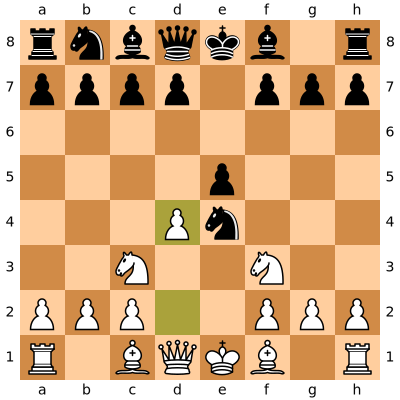

The game was abandoned.


In [9]:
# Play against DeepChess
chess_playing_environment.play()